# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



-----
# PREFACE: Bottom Up to Top Down

In [1]:
from torchvision.models import list_models, get_model, get_model_weights, ResNet18_Weights

# First look at all the models just in Torchvision.
print(f'# Models in Torchvision: {len(list_models())}')
for model_name in list_models():
    weights_enum = list(get_model_weights(model_name))
    print(f'{model_name}: {weights_enum[0].meta['num_params'] / (1024*1024):3.1f} GB')

# Models in Torchvision: 121
alexnet: 58.3 GB
convnext_base: 84.5 GB
convnext_large: 188.6 GB
convnext_small: 47.9 GB
convnext_tiny: 27.3 GB
deeplabv3_mobilenet_v3_large: 10.5 GB
deeplabv3_resnet101: 58.2 GB
deeplabv3_resnet50: 40.1 GB
densenet121: 7.6 GB
densenet161: 27.4 GB
densenet169: 13.5 GB
densenet201: 19.1 GB
efficientnet_b0: 5.0 GB
efficientnet_b1: 7.4 GB
efficientnet_b2: 8.7 GB
efficientnet_b3: 11.7 GB
efficientnet_b4: 18.4 GB
efficientnet_b5: 29.0 GB
efficientnet_b6: 41.0 GB
efficientnet_b7: 63.3 GB
efficientnet_v2_l: 113.0 GB
efficientnet_v2_m: 51.6 GB
efficientnet_v2_s: 20.5 GB
fasterrcnn_mobilenet_v3_large_320_fpn: 18.5 GB
fasterrcnn_mobilenet_v3_large_fpn: 18.5 GB
fasterrcnn_resnet50_fpn: 39.8 GB
fasterrcnn_resnet50_fpn_v2: 41.7 GB
fcn_resnet101: 51.8 GB
fcn_resnet50: 33.7 GB
fcos_resnet50_fpn: 30.8 GB
googlenet: 6.3 GB
inception_v3: 25.9 GB
keypointrcnn_resnet50_fpn: 56.4 GB
lraspp_mobilenet_v3_large: 3.1 GB
maskrcnn_resnet50_fpn: 42.3 GB
maskrcnn_resnet50_fpn_v2: 44.2 

In [2]:
# Enough faffing around. Let's take a specific model: ResNet-18
model = get_model('resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

# Stop and appreciate the complexity... And... Why am I calling model.eval() here?
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

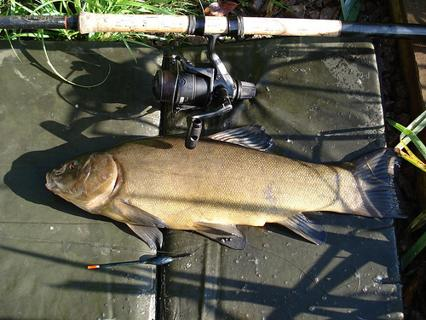

In [3]:
# Get some data.
from torchvision.datasets import Imagenette
ds = Imagenette(root='./data', size='320px', download=True)
(img, label) = ds[1]
img

In [4]:
img = ResNet18_Weights.IMAGENET1K_V1.transforms()(img)
model(img.unsqueeze(0)).argmax() # Why must I .unsqueeze(0) the image?

tensor(0)

----

## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [5]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [6]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [7]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [8]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 19: 100%|█████████████████████| 215/215 [00:01<00:00, 130.43it/s]
                                                                                

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.951     0.980     0.965       980
           1      0.969     0.980     0.974      1135
           2      0.916     0.895     0.905      1032
           3      0.891     0.921     0.906      1010
           4      0.909     0.929     0.919       982
           5      0.921     0.844     0.881       892
           6      0.945     0.947     0.946       958
           7      0.937     0.922     0.929      1028
           8      0.861     0.884     0.872       974
           9      0.911     0.900     0.905      1009

    accuracy                          0.921     10000
   macro avg      0.921     0.920     0.920     10000
weighted avg      0.922     0.921     0.921     10000



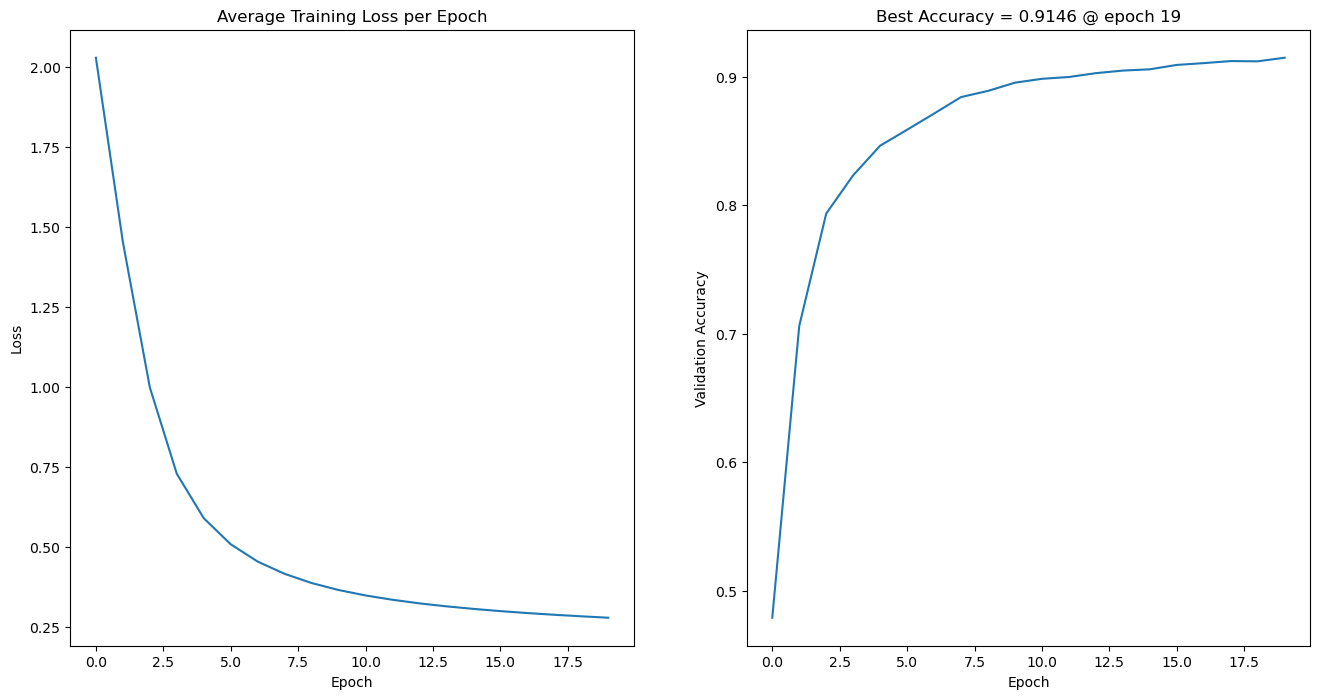

In [9]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 20
lr = 0.0001
batch_size = 256

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

Let's first inspect my parameterized MLP created using a ModuleList. Note that it contains a single submodule called `layers`:

In [13]:
model_mlp

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

The `layers` submodule contains three *unnamed* submodules. If you use `nn.Sequential` instead of `nn.ModuleList` the `.forward()` method becomes much simpler.

An equivalent, non-parameterized version might be:

In [22]:
# Your code here.
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, 10)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

model_mymlp = MyMLP()
model_mymlp

MyMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)

Now let's train one of these MLPs to see how it works...

Training epoch 19: 100%|█████████████████████| 215/215 [00:01<00:00, 132.20it/s]
                                                                                

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.962     0.976     0.969       980
           1      0.971     0.979     0.975      1135
           2      0.941     0.917     0.929      1032
           3      0.930     0.920     0.925      1010
           4      0.930     0.944     0.937       982
           5      0.929     0.905     0.917       892
           6      0.941     0.959     0.950       958
           7      0.940     0.936     0.938      1028
           8      0.909     0.912     0.910       974
           9      0.921     0.927     0.924      1009

    accuracy                          0.938     10000
   macro avg      0.937     0.937     0.937     10000
weighted avg      0.938     0.938     0.938     10000



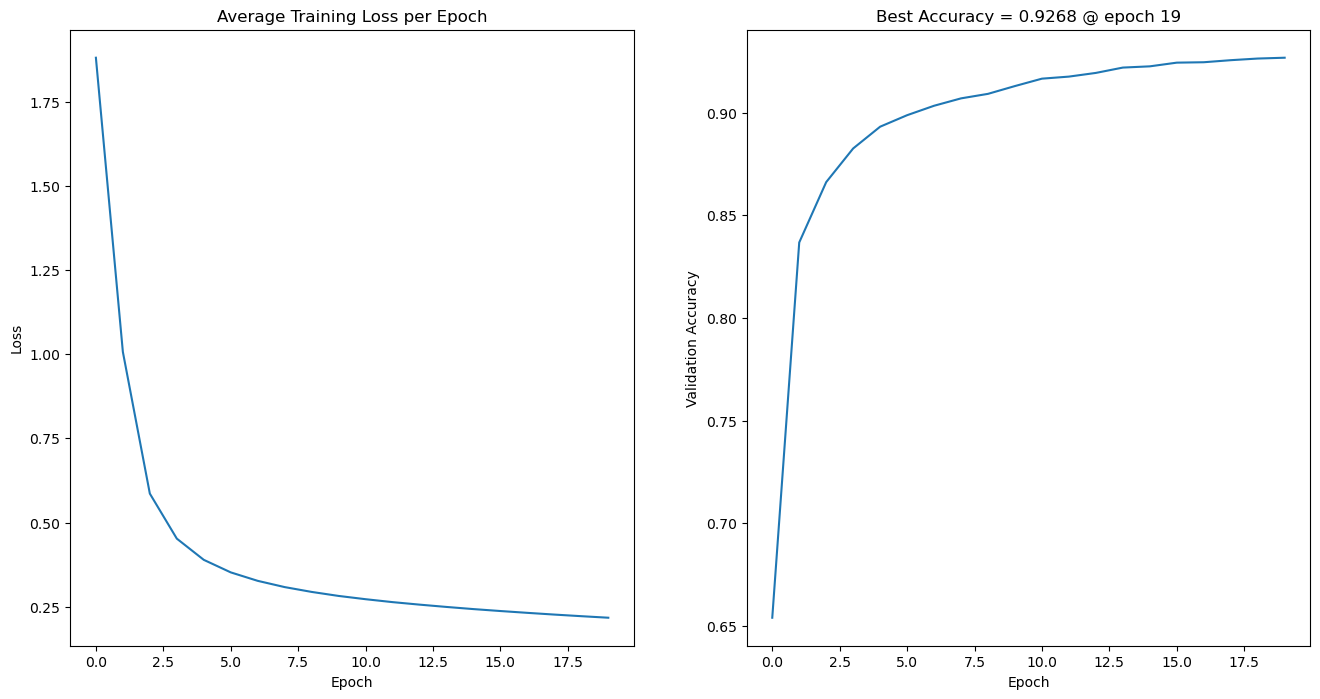

In [23]:
model = MLP([28*28, 32, 32, 10]).to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model, dl_test, device=device)[1]}')

## Using TensorBoard to monitor training

Instead of generating plots inline like above, it is generally better to use something like [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) or [Comet](https://www.comet.com/site/) or [Weights and Biases](https://wandb.ai/site/) to track training runs. Here is a simple toplevel training loop that logs training loss and validation accuracy. To run the TensorBoard webapp you must run (in the same directory where the `runs/` directory is created):

    tensorboard --logdir=./runs


In [25]:
from torch.utils.tensorboard import SummaryWriter

# A better training loop.
def train_model(model, epochs, opt, dl_train, dl_val, logdir, device='cpu', verbose=False):
    writer = SummaryWriter(logdir)
    for epoch in range(epochs):
        loss = train_epoch(model, dl_train, opt, epoch, device=device)
        (val_acc, _) = evaluate_model(model, dl_val, device=device)
        writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalar('Acc/val', val_acc, epoch)
    writer.close()

The code below will perform three training runs for different depths of MLPs. The results can be plotted and compared in the TensorBoard interface.

In [26]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 50
lr = 0.0001
batch_size = 256
seed = 1023
torch.manual_seed(seed)

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

width = 32

# Tensorboard logfile template.
model_type = 'MLP'
logdir = f'runs/{model_type}-width={width}-depth={depth}-bs={batch_size}-lr={lr}'
for depth in [10, 20, 30]:
    model = MLP([28*28] + [width]*depth + [10]).to(device)
    opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    train_model(model, epochs, opt, dl_train, dl_val,
                logdir=f'runs/NONRESIDUAL-width={width}-depth={depth}-bs={batch_size}-lr={lr}-seed={seed}',
                device=device,
                verbose=True)

Training epoch 49: 100%|█████████████████████| 215/215 [00:01<00:00, 119.43it/s]
                                                                                

## What's going wrong?

The results of the depth-10 and depth-20 MLPs are kind of OK (although the depth-20 MLP takes some time to start learning). Let's see if there is anything "strange" about the gradients of the loss on the last batch for the depth-30 network. Note that the gradients with respect to each parameter are **conveniently still contained in the tensors** of the model (since we don't call `.zero_grad()` after training).

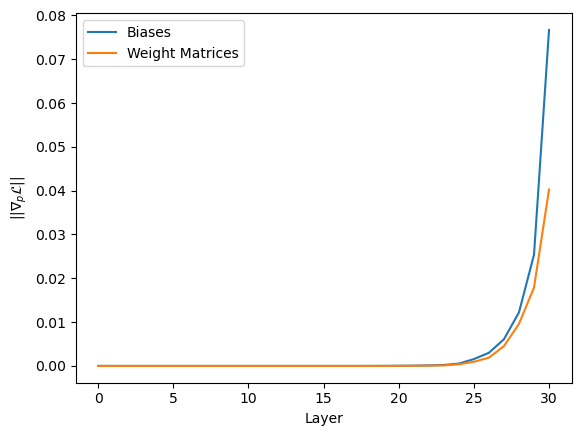

In [59]:
# Get the tensors corresponding to the gradients of bias parameters.
biases = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 1]

# And get the tensors corresponding to the gradients of weight matrices.
weights = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 2]

# Plot the norms of the biases.
plt.plot([(p * p).sum().sqrt().item() for p in biases])
plt.plot([(p * p).sum().sqrt().item() for p in weights])
plt.xlabel('Layer')
plt.ylabel('$||\\nabla_p \\mathcal{L}||$')
plt.legend(['Biases', 'Weight Matrices'])
plt.title('MLP Gradient Norm Analysis')

This analysis effectively demonstrates that there is **no gradient signal arriving to the early layers of the network**. Extending the training to more epochs *might* help, but let's see if **residual connections** do the trick...

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [67]:
# Your code here.
class ResMLPBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc1 = nn.Linear(width, width)
        self.fc2 = nn.Linear(width, width)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return out + x
        
class ResMLP(nn.Module):
    def __init__(self, input_size, inner_size, num_blocks, output_size):
        super().__init__()
        self.input_adapter = nn.Linear(input_size, inner_size)
        self.blocks = nn.Sequential(*([ResMLPBlock(inner_size)] * num_blocks))  # Implemented with nn.Sequential this time!
        self.output_adapter = nn.Linear(inner_size, output_size)
    
    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.input_adapter(x))
        x = self.blocks(x)
        return self.output_adapter(x)

In [68]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 50
lr = 0.0001
batch_size = 256
seed = 1023
torch.manual_seed(seed)

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

width = 32

# Main training loop. Note that each residual block is TWO layers, so we use *half* the depth as above.
for depth in [5, 10, 15]:
    model = ResMLP(28*28, width, depth, 10).to(device)
    opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    train_model(model, epochs, opt, dl_train, dl_val,
                logdir=f'runs/RESIDUAL-width={width}-depth={depth}-bs={batch_size}-lr={lr}-seed={seed}',
                device=device,
                verbose=True)

Training epoch 49: 100%|█████████████████████| 215/215 [00:01<00:00, 117.94it/s]
                                                                                

If we repeat the analysis of gradient magnitudes for the final residual module, we see that there is **much** more gradient signal propagating through the network.

Text(0.5, 1.0, 'Residual Gradient Norm Analysis')

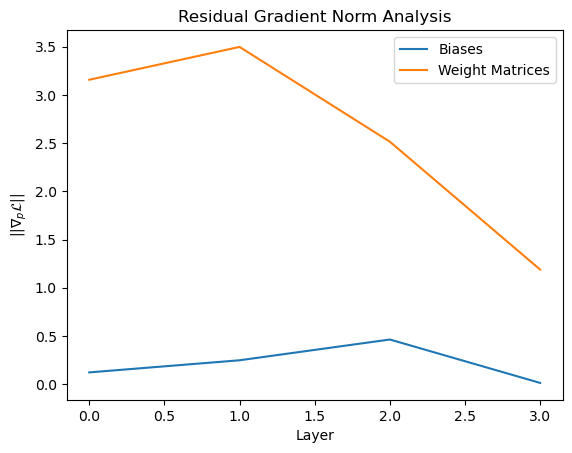

In [70]:
# Get the tensors corresponding to the gradients of bias parameters.
biases = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 1]

# And get the tensors corresponding to the gradients of weight matrices.
weights = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 2]

# Plot the norms of the biases.
plt.plot([(p * p).sum().sqrt().item() for p in biases])
plt.plot([(p * p).sum().sqrt().item() for p in weights])
plt.xlabel('Layer')
plt.ylabel('$||\\nabla_p \\mathcal{L}||$')
plt.legend(['Biases', 'Weight Matrices'])
plt.title('Residual Gradient Norm Analysis')

And in TensorBoard we can confirm that the *loss* for `ResMLP` converges to a significantly lower value than for the non-residual `MLP`. There is evidence of overfitting, though.

### END OF MY DISORGANIZED RAVINGS
----

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
# Your code here.

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.